<a href="https://colab.research.google.com/github/KaziMuktadirAhmed/WISER-womenium-2025-project-1/blob/saad/The_Wiser_Noise_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#using a noise model from real hardware

In [ ]:
# Step 1: Run this cell first to install all necessary packages.
# After this finishes, you MUST restart the runtime.
# Go to the menu: Runtime -> Restart session
!pip install -q qiskit qiskit-aer matplotlib pylatexenc
!pip install qiskit-ibm-runtime
print("✅ All packages installed successfully. Please restart the runtime now.")

#Load IBM Quantum Account

In [4]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeVigoV2


# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit_ibm_runtime.fake_provider import FakeVigoV2
device_backend = FakeVigoV2()

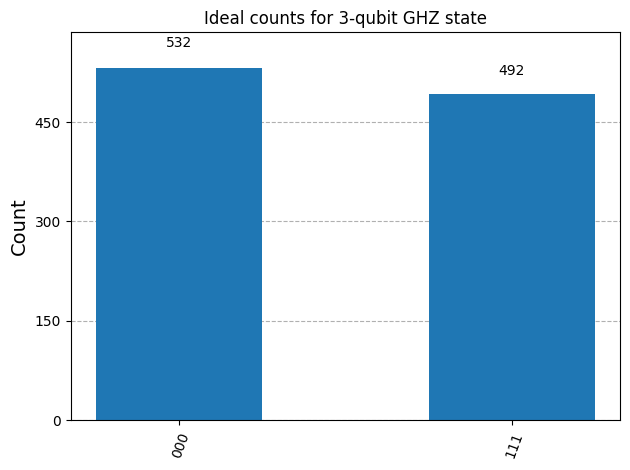

In [ ]:
# Construct quantum circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])

sim_ideal = AerSimulator()

# Execute and get counts
result = sim_ideal.run(transpile(circ, sim_ideal)).result()
counts = result.get_counts(0)
plot_histogram(counts, title='Ideal counts for 3-qubit GHZ state')

In [ ]:
sim_vigo = AerSimulator.from_backend(device_backend)

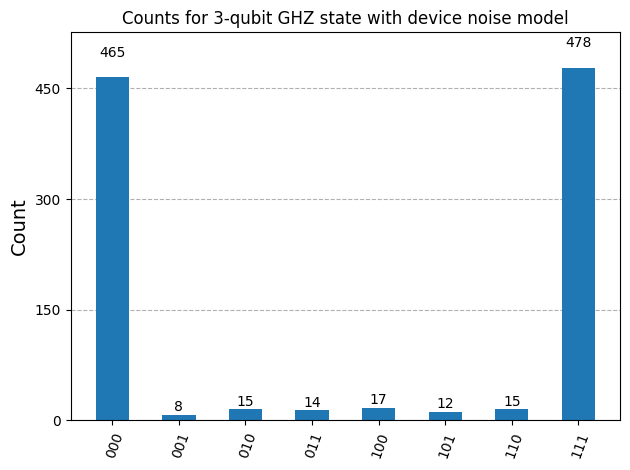

In [ ]:
# Transpile the circuit for the noisy basis gates
tcirc = transpile(circ, sim_vigo)

# Execute noisy simulation and get counts
result_noise = sim_vigo.run(tcirc).result()
counts_noise = result_noise.get_counts(0)
plot_histogram(counts_noise,
               title="Counts for 3-qubit GHZ state with device noise model")


--- Circuit Information for 4-Layer QGB ---
Circuit depth: 46
Number of qubits: 10
Number of classical bits: 5

Available devices: ['manhattan', 'torino']

Circuit diagram:
           ░      ┌─────────┐   ┌───┐    ░      ┌───────────┐   ┌───┐   ┌───┐   ┌───┐    ░      ┌─────────────┐   ┌───┐»
q_0: ──────░──|0>─┤ Ry(π/3) ├─■─┤ X ├─■──░──|0>─┤ Ry(4π/15) ├─■─┤ X ├─■─┤ X ├─■─┤ X ├─■──░──|0>─┤ Ry(0.67021) ├─■─┤ X ├»
           ░      └─────────┘ │ └─┬─┘ │  ░      └───────────┘ │ └─┬─┘ │ └─┬─┘ │ └─┬─┘ │  ░      └─────────────┘ │ └─┬─┘»
q_1: ──────░──────────────────┼───┼───┼──░────────────────────┼───┼───┼───┼───┼───┼───┼──░──────────────────────┼───┼──»
           ░                  │   │   │  ░                    │   │   │   │   │   │   │  ░                      │   │  »
q_2: ──────░──────────────────┼───┼───┼──░────────────────────┼───┼───┼───┼───┼───┼───┼──░──────────────────────X───┼──»
           ░                  │   │   │  ░                    │   │   │   │   │   │   │  ░          

/tmp/ipython-input-2222487360.py:315: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  ideal_dist, noisy_dist, noise_model = compare_ideal_vs_noisy(qgb_circuit, N_LAYERS, shots=8192, device_name=TEST_DEVICE)


Ideal Results (Probabilities):
{0: 0.5166015625, 1: 0.3812255859375, 2: 0.09423828125, 3: 0.0076904296875, 4: 0.000244140625}

=== NOISY SIMULATION ===
Using device: fake_manhattan
Circuit requires 10 qubits, device has 65 qubits
High optimization failed: 'A connected component of the DAGCircuit is too large for any of the connected components in the coupling map'
Trying with coupling map disabled...
Original circuit depth: 46
Transpiled circuit depth: 318
Number of qubits on device: 65
Noisy Results (Probabilities):
{0: 0.3035888671875, 1: 0.28369140625, 2: 0.1614990234375, 3: 0.125244140625, 4: 0.007080078125}


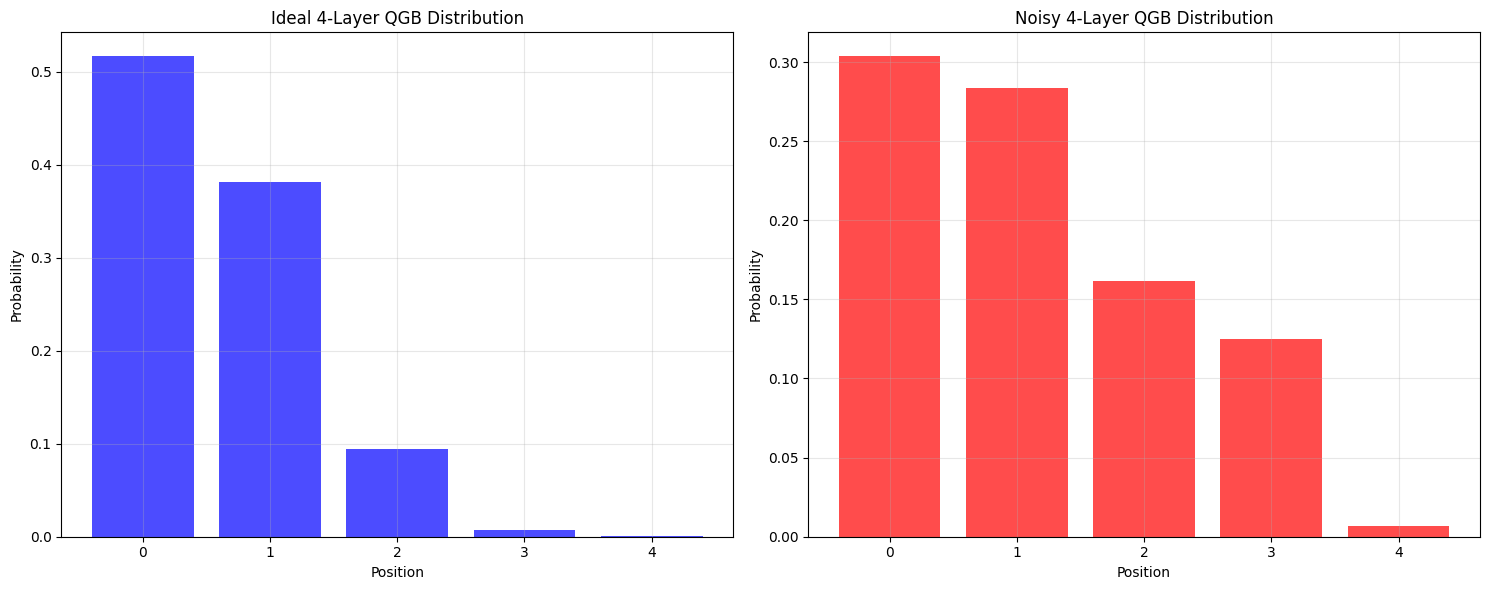


--- Noise Model Information ---
Device used: manhattan
Noise model type: <class 'qiskit_aer.noise.noise_model.NoiseModel'>
Number of noise instructions: 6

--- Difference Analysis ---
Position 0: Ideal=0.5166, Noisy=0.3036, Diff=0.2130
Position 1: Ideal=0.3812, Noisy=0.2837, Diff=0.0975
Position 2: Ideal=0.0942, Noisy=0.1615, Diff=0.0673
Position 3: Ideal=0.0077, Noisy=0.1252, Diff=0.1176
Position 4: Ideal=0.0002, Noisy=0.0071, Diff=0.0068

Total Variation Distance: 0.2511
Jensen-Shannon Divergence: 0.0812
Wasserstein Distance: 0.3813


In [9]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeManhattanV2, FakeTorino
from qiskit_aer.noise import NoiseModel
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from collections import defaultdict
import os

try:
    from IPython.display import display
    IS_IPYTHON = True
except ImportError:
    IS_IPYTHON = False

def create_n_layer_qgb(n_layers: int, target_distribution="exponential_custom"):
    """
    Generates a Qiskit QuantumCircuit for an N-layer Quantum Galton Board with a left-skewed exponential distribution.
    """
    num_working_qubits = 2 * n_layers + 1
    num_qubits = num_working_qubits + 1
    num_clbits = n_layers + 1

    qc = QuantumCircuit(num_qubits, num_clbits, name=f"{n_layers}-Layer QGB")

    control_qubit = 0

    # --- Step 1: Initialization ---
    initial_ball_pos = n_layers + 1
    qc.x(initial_ball_pos)
    qc.barrier()

    # --- Step 2: Build the Layers ---
    for layer in range(n_layers):
        qc.reset(control_qubit)

        base_bias = np.pi/3
        decay_factor = 0.8
        bias_angle = base_bias * (decay_factor ** layer)
        qc.ry(bias_angle, control_qubit)

        peg_positions = range(n_layers + 1 - layer, n_layers + 1 + layer + 1, 2)

        for i, peg_pos in enumerate(peg_positions):
            left_channel = peg_pos - 1
            right_channel = peg_pos + 1

            qc.cswap(control_qubit, left_channel, peg_pos)
            qc.cx(peg_pos, control_qubit)
            qc.cswap(control_qubit, peg_pos, right_channel)

            if i < len(peg_positions) - 1:
                qc.cx(right_channel, control_qubit)

        qc.barrier()

    # --- Step 3: Measurement ---
    output_qubits = range(1, num_working_qubits + 2, 2)
    qc.measure(output_qubits, range(num_clbits))

    return qc

def get_available_devices():
    """
    List available fake backend devices
    """
    devices = {
        'manhattan': FakeManhattanV2,
        'torino': FakeTorino,
    }
    return devices

def run_noisy_simulation(circuit, shots=8192, device_name='manhattan'):
    """
    Run the circuit with device noise model simulation
    """
    # Get available devices
    devices = get_available_devices()

    # Create fake device backend
    if device_name.lower() in devices:
        fake_device = devices[device_name.lower()]()
    else:
        print(f"Unknown device '{device_name}'. Available devices: {list(devices.keys())}")
        print("Using default: FakeManhattan")
        fake_device = FakeManhattan()

    print(f"Using device: {fake_device.name}")
    print(f"Circuit requires {circuit.num_qubits} qubits, device has {fake_device.num_qubits} qubits")

    # Check if circuit fits on device
    if circuit.num_qubits > fake_device.num_qubits:
        print(f"WARNING: Circuit needs {circuit.num_qubits} qubits but device only has {fake_device.num_qubits}")
        print("Falling back to noise-model-only simulation (no coupling map constraints)")

        # Create noise model from the fake device
        noise_model = NoiseModel.from_backend(fake_device)

        # Create AerSimulator with noise model
        sim_noisy = AerSimulator(noise_model=noise_model)

        # Transpile with basic optimization only
        transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=0)

    else:
        # Create noise model from the fake device
        noise_model = NoiseModel.from_backend(fake_device)

        # Get device properties
        coupling_map = fake_device.coupling_map
        basis_gates = fake_device.basis_gates

        # Create AerSimulator with noise model
        sim_noisy = AerSimulator(
            noise_model=noise_model,
            coupling_map=coupling_map,
            basis_gates=basis_gates
        )

        # Transpile circuit for the noisy backend with higher optimization
        try:
            transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=3)
        except Exception as e:
            print(f"High optimization failed: {e}")
            print("Trying with coupling map disabled...")
            sim_noisy = AerSimulator(noise_model=noise_model)
            transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=1)

    print(f"Original circuit depth: {circuit.depth()}")
    print(f"Transpiled circuit depth: {transpiled_circuit.depth()}")
    print(f"Number of qubits on device: {fake_device.num_qubits}")

    # Run the noisy simulation
    job = sim_noisy.run(transpiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts(0)

    return counts, noise_model, transpiled_circuit

def compare_ideal_vs_noisy(circuit, n_layers, shots=8192, device_name='manhattan'):
    """
    Compare ideal simulation vs noisy simulation results
    """
    print("=== IDEAL SIMULATION ===")

    # Use the original Sampler (V1) for compatibility
    sampler = Sampler()
    job = sampler.run(circuit, shots=shots)
    result = job.result()

    # Get counts from the result
    counts_data = result.quasi_dists[0]

    # Convert quasi-distribution to counts and then to probabilities
    ideal_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for outcome, probability in counts_data.items():
        # Convert integer outcome to binary string
        bitstring = format(outcome, f'0{n_layers + 1}b')
        try:
            position = bitstring.index('1')
            ideal_distribution[position] += probability
        except ValueError:
            pass

    print("Ideal Results (Probabilities):")
    print({k: v for k, v in sorted(ideal_distribution.items())})

    print("\n=== NOISY SIMULATION ===")
    # Run noisy simulation
    noisy_counts, noise_model, transpiled_circuit = run_noisy_simulation(circuit, shots, device_name)

    # Convert counts to probabilities
    total_shots = sum(noisy_counts.values())
    noisy_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for bitstring, count in noisy_counts.items():
        prob = count / total_shots
        try:
            position = bitstring.index('1')
            noisy_distribution[position] += prob
        except ValueError:
            pass

    print("Noisy Results (Probabilities):")
    print({k: v for k, v in sorted(noisy_distribution.items())})

    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Ideal histogram
    positions = list(ideal_distribution.keys())
    probabilities = list(ideal_distribution.values())
    ax1.bar(positions, probabilities, alpha=0.7, color='blue')
    ax1.set_title(f'Ideal {n_layers}-Layer QGB Distribution')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Probability')
    ax1.grid(True, alpha=0.3)

    # Noisy histogram
    positions_noisy = list(noisy_distribution.keys())
    probabilities_noisy = list(noisy_distribution.values())
    ax2.bar(positions_noisy, probabilities_noisy, alpha=0.7, color='red')
    ax2.set_title(f'Noisy {n_layers}-Layer QGB Distribution')
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Probability')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if IS_IPYTHON:
        display(fig)
    else:
        plt.show()

    return ideal_distribution, noisy_distribution, noise_model



def total_variation_distance(ideal_dist, noisy_dist):
    total_var_distance = 0.0
    keys = set(ideal_dist.keys()).union(set(noisy_dist.keys()))
    for key in keys:
        total_var_distance += abs(ideal_dist.get(key, 0.0) - noisy_dist.get(key, 0.0))
    return total_var_distance / 2





def jensen_shannon_divergence(dist_p, dist_q):
    """
    Calculate the Jensen-Shannon divergence between two probability distributions.
    The distributions are dictionaries with keys as outcomes and values as probabilities.
    """
    # Combine all keys in both distributions
    keys = set(dist_p.keys()).union(set(dist_q.keys()))

    # Create probability arrays aligned on the union of keys
    p = np.array([dist_p.get(k, 0.0) for k in keys])
    q = np.array([dist_q.get(k, 0.0) for k in keys])

    # Normalize distributions in case they don't sum exactly to 1
    p = p / p.sum()
    q = q / q.sum()

    # Midpoint distribution
    m = 0.5 * (p + q)

    # Define a helper function for KL divergence with zero handling
    def kl_divergence(a, b):
        mask = (a > 0) & (b > 0)
        return np.sum(a[mask] * np.log2(a[mask] / b[mask]))

    # Jensen-Shannon divergence
    jsd = 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)
    return jsd




def wasserstein_distance(dist_p, dist_q):
    """
    Calculate the 1D Wasserstein distance between two probability distributions.
    Distributions are dictionaries with discrete positions as keys and probabilities as values.
    """
    # Sort all possible positions from both distributions
    positions = sorted(set(dist_p.keys()).union(set(dist_q.keys())))

    # Create aligned probability vectors
    p = np.array([dist_p.get(pos, 0.0) for pos in positions])
    q = np.array([dist_q.get(pos, 0.0) for pos in positions])

    # Normalize the distributions to sum to 1
    p = p / p.sum() if p.sum() > 0 else p
    q = q / q.sum() if q.sum() > 0 else q

    # Compute cumulative distribution functions (CDFs)
    cdf_p = np.cumsum(p)
    cdf_q = np.cumsum(q)

    # Compute Wasserstein distance as the sum of absolute differences of CDFs times gaps between positions
    distance = np.sum(np.abs(cdf_p - cdf_q) * np.diff([0] + positions))

    return distance



# --- Example Usage ---
if __name__ == '__main__':
    N_LAYERS = 4

    qgb_circuit = create_n_layer_qgb(N_LAYERS)

    print(f"\n--- Circuit Information for {N_LAYERS}-Layer QGB ---")
    print(f"Circuit depth: {qgb_circuit.depth()}")
    print(f"Number of qubits: {qgb_circuit.num_qubits}")
    print(f"Number of classical bits: {qgb_circuit.num_clbits}")

    # Print available devices
    devices = get_available_devices()
    print(f"\nAvailable devices: {list(devices.keys())}")

    print("\nCircuit diagram:")
    print(qgb_circuit.draw(fold=120))

    print(f"\n--- Comparing Ideal vs Noisy Simulation for {N_LAYERS}-Layer QGB ---")

    # Test device name
    TEST_DEVICE = 'manhattan'

    # Compare ideal and noisy results
    ideal_dist, noisy_dist, noise_model = compare_ideal_vs_noisy(qgb_circuit, N_LAYERS, shots=8192, device_name=TEST_DEVICE)

    # --- Noise Model Information ---
    print(f"\n--- Noise Model Information ---")
    print(f"Device used: {TEST_DEVICE}")
    print(f"Noise model type: {type(noise_model)}")
    print(f"Number of noise instructions: {len(noise_model._noise_instructions) if hasattr(noise_model, '_noise_instructions') else 'N/A'}")

    print(f"\n--- Difference Analysis ---")
    total_var_distance_sum = 0
    for position in range(N_LAYERS + 1):
        ideal_prob = ideal_dist.get(position, 0.0)
        noisy_prob = noisy_dist.get(position, 0.0)
        difference = abs(ideal_prob - noisy_prob)
        total_var_distance_sum += difference
        print(f"Position {position}: Ideal={ideal_prob:.4f}, Noisy={noisy_prob:.4f}, Diff={difference:.4f}")

    total_variation_distance_value = total_variation_distance(ideal_dist, noisy_dist)
    print(f"\nTotal Variation Distance: {total_variation_distance_value:.4f}")

    js_divergence = jensen_shannon_divergence(ideal_dist, noisy_dist)
    print(f"Jensen-Shannon Divergence: {js_divergence:.4f}")

    wasserstein_dist = wasserstein_distance(ideal_dist, noisy_dist)
    print(f"Wasserstein Distance: {wasserstein_dist:.4f}")




    plt.close('all')


--- Circuit Information for 4-Layer QGB ---
Circuit depth: 46
Number of qubits: 10
Number of classical bits: 5

Available fake devices: ['manhattan', 'torino']

Circuit diagram:
           ░      ┌─────────┐   ┌───┐    ░      ┌───────────┐   ┌───┐   ┌───┐   ┌───┐    ░      ┌─────────────┐   ┌───┐»
q_0: ──────░──|0>─┤ Ry(π/3) ├─■─┤ X ├─■──░──|0>─┤ Ry(4π/15) ├─■─┤ X ├─■─┤ X ├─■─┤ X ├─■──░──|0>─┤ Ry(0.67021) ├─■─┤ X ├»
           ░      └─────────┘ │ └─┬─┘ │  ░      └───────────┘ │ └─┬─┘ │ └─┬─┘ │ └─┬─┘ │  ░      └─────────────┘ │ └─┬─┘»
q_1: ──────░──────────────────┼───┼───┼──░────────────────────┼───┼───┼───┼───┼───┼───┼──░──────────────────────┼───┼──»
           ░                  │   │   │  ░                    │   │   │   │   │   │   │  ░                      │   │  »
q_2: ──────░──────────────────┼───┼───┼──░────────────────────┼───┼───┼───┼───┼───┼───┼──░──────────────────────X───┼──»
           ░                  │   │   │  ░                    │   │   │   │   │   │   │  ░     

/tmp/ipython-input-3623772022.py:150: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  ideal_dist = get_ideal_distribution(circuit, n_layers, shots)



=== NOISY SIMULATION ===
Using fake device: fake_manhattan
Circuit qubits required: 10, device qubits available: 65
High optimization level transpile failed: 'A connected component of the DAGCircuit is too large for any of the connected components in the coupling map'
Trying transpilation with coupling map disabled.
Original circuit depth: 46
Transpiled circuit depth: 318
Ideal Results (Probabilities):
{0: 0.5169677734375, 1: 0.3765869140625, 2: 0.09619140625, 3: 0.0101318359375, 4: 0.0001220703125}
Noisy Results (Probabilities):
{0: 0.301025390625, 1: 0.291259765625, 2: 0.1575927734375, 3: 0.1243896484375, 4: 0.008056640625}


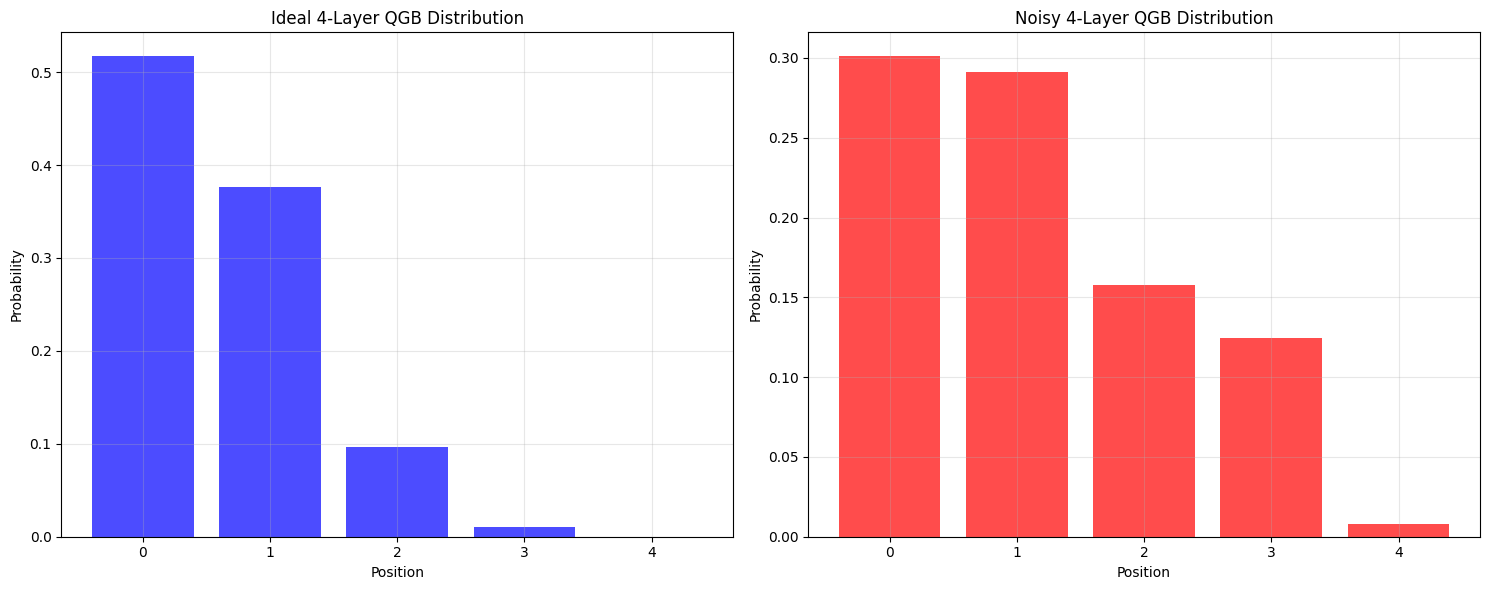


--- Noise Model Information ---
Device used: manhattan
Noise model type: <class 'qiskit_aer.noise.noise_model.NoiseModel'>
Number of noise instructions: 6

--- Difference Analysis ---
Position 0: Ideal=0.5170, Noisy=0.3010, Diff=0.2159
Position 1: Ideal=0.3766, Noisy=0.2913, Diff=0.0853
Position 2: Ideal=0.0962, Noisy=0.1576, Diff=0.0614
Position 3: Ideal=0.0101, Noisy=0.1244, Diff=0.1143
Position 4: Ideal=0.0001, Noisy=0.0081, Diff=0.0079

Total Variation Distance: 0.2424
Jensen-Shannon Divergence: 0.0761
Wasserstein Distance: 0.3711
Kullback-Leibler Distance: 0.4370


In [15]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeManhattanV2, FakeTorino
from qiskit_aer.noise import NoiseModel
from collections import defaultdict
import matplotlib.pyplot as plt

try:
    from IPython.display import display
    IS_IPYTHON = True
except ImportError:
    IS_IPYTHON = False


def create_n_layer_qgb(n_layers: int):
    """Generates an N-layer Quantum Galton Board QuantumCircuit."""
    num_working_qubits = 2 * n_layers + 1
    num_qubits = num_working_qubits + 1
    num_clbits = n_layers + 1

    qc = QuantumCircuit(num_qubits, num_clbits, name=f"{n_layers}-Layer QGB")
    control_qubit = 0

    # Initialization
    qc.x(n_layers + 1)
    qc.barrier()

    # Build Layers
    for layer in range(n_layers):
        qc.reset(control_qubit)

        bias_angle = (np.pi / 3) * (0.8 ** layer)
        qc.ry(bias_angle, control_qubit)

        peg_positions = range(n_layers + 1 - layer, n_layers + 1 + layer + 1, 2)

        for i, peg_pos in enumerate(peg_positions):
            left_channel = peg_pos - 1
            right_channel = peg_pos + 1

            qc.cswap(control_qubit, left_channel, peg_pos)
            qc.cx(peg_pos, control_qubit)
            qc.cswap(control_qubit, peg_pos, right_channel)

            if i < len(peg_positions) - 1:
                qc.cx(right_channel, control_qubit)

        qc.barrier()

    # Measurement
    output_qubits = range(1, num_working_qubits + 2, 2)
    qc.measure(output_qubits, range(num_clbits))

    return qc


def get_fake_device(device_name: str):
    """Return the fake backend device object or default to FakeManhattanV2."""
    devices = {
        'manhattan': FakeManhattanV2,
        'torino': FakeTorino,
    }
    device_cls = devices.get(device_name.lower(), FakeManhattanV2)
    return device_cls()


def create_simulator_and_transpile(circuit, fake_device):
    """Create AerSimulator with noise model and transpile the circuit accordingly."""
    noise_model = NoiseModel.from_backend(fake_device)

    if circuit.num_qubits > fake_device.num_qubits:
        print(f"WARNING: Circuit requires {circuit.num_qubits} qubits but device only has {fake_device.num_qubits}.")
        print("Running noise-model-only simulation without coupling map constraints.")
        sim = AerSimulator(noise_model=noise_model)
        transpiled = transpile(circuit, sim, optimization_level=0)
    else:
        sim = AerSimulator(
            noise_model=noise_model,
            coupling_map=fake_device.coupling_map,
            basis_gates=fake_device.basis_gates
        )
        try:
            transpiled = transpile(circuit, sim, optimization_level=3)
        except Exception as e:
            print(f"High optimization level transpile failed: {e}")
            print("Trying transpilation with coupling map disabled.")
            sim = AerSimulator(noise_model=noise_model)
            transpiled = transpile(circuit, sim, optimization_level=1)

    return sim, transpiled, noise_model


def run_noisy_simulation(circuit, shots=8192, device_name='manhattan'):
    """Run noisy simulation using the specified fake device."""
    fake_device = get_fake_device(device_name)
    print(f"Using fake device: {fake_device.name}")
    print(f"Circuit qubits required: {circuit.num_qubits}, device qubits available: {fake_device.num_qubits}")

    sim, transpiled_circuit, noise_model = create_simulator_and_transpile(circuit, fake_device)

    print(f"Original circuit depth: {circuit.depth()}")
    print(f"Transpiled circuit depth: {transpiled_circuit.depth()}")

    job = sim.run(transpiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts(0)

    return counts, noise_model, transpiled_circuit


def convert_counts_to_distribution(counts, n_layers):
    """Convert raw counts to a probability distribution indexed by position."""
    total = sum(counts.values())
    distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for bitstring, count in counts.items():
        prob = count / total
        try:
            position = bitstring.index('1')
            distribution[position] += prob
        except ValueError:
            # If no '1' found in bitstring, skip this outcome
            continue
    return distribution


def get_ideal_distribution(circuit, n_layers, shots=8192):
    """Run ideal (noiseless) simulation using Sampler and return distribution."""
    print("=== IDEAL SIMULATION ===")
    sampler = Sampler()
    job = sampler.run(circuit, shots=shots)
    result = job.result()
    quasi_dist = result.quasi_dists[0]  # dict of int outcome -> probability

    dist = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})
    for outcome, prob in quasi_dist.items():
        bitstring = format(outcome, f'0{n_layers + 1}b')
        try:
            position = bitstring.index('1')
            dist[position] += prob
        except ValueError:
            continue
    return dist


def compare_ideal_vs_noisy(circuit, n_layers, shots=8192, device_name='manhattan'):
    """Compare ideal and noisy distributions and plot histograms side-by-side."""
    ideal_dist = get_ideal_distribution(circuit, n_layers, shots)

    print("\n=== NOISY SIMULATION ===")
    noisy_counts, noise_model, _ = run_noisy_simulation(circuit, shots, device_name)
    noisy_dist = convert_counts_to_distribution(noisy_counts, n_layers)

    print("Ideal Results (Probabilities):")
    print(dict(sorted(ideal_dist.items())))
    print("Noisy Results (Probabilities):")
    print(dict(sorted(noisy_dist.items())))

    # Plot distributions
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    for ax, dist, color, title in zip(
        axs,
        [ideal_dist, noisy_dist],
        ['blue', 'red'],
        [f'Ideal {n_layers}-Layer QGB Distribution', f'Noisy {n_layers}-Layer QGB Distribution']
    ):
        positions = list(dist.keys())
        probabilities = list(dist.values())
        ax.bar(positions, probabilities, alpha=0.7, color=color)
        ax.set_title(title)
        ax.set_xlabel('Position')
        ax.set_ylabel('Probability')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()

    if IS_IPYTHON:
        display(fig)
    else:
        plt.show()

    return ideal_dist, noisy_dist, noise_model


def total_variation_distance(dist1, dist2):
    """Calculate total variation distance between two distributions."""
    keys = set(dist1.keys()).union(dist2.keys())
    return 0.5 * sum(abs(dist1.get(k, 0.0) - dist2.get(k, 0.0)) for k in keys)


def jensen_shannon_divergence(dist_p, dist_q):
    """Calculate Jensen-Shannon divergence between two distributions."""
    keys = set(dist_p.keys()).union(dist_q.keys())
    p = np.array([dist_p.get(k, 0.0) for k in keys])
    q = np.array([dist_q.get(k, 0.0) for k in keys])
    p /= p.sum()
    q /= q.sum()
    m = 0.5 * (p + q)

    def kl_div(a, b):
        mask = (a > 0) & (b > 0)
        return np.sum(a[mask] * np.log2(a[mask] / b[mask]))

    return 0.5 * kl_div(p, m) + 0.5 * kl_div(q, m)


def wasserstein_distance(dist_p, dist_q):
    """Calculate 1D Wasserstein distance between two discrete distributions."""
    positions = sorted(set(dist_p.keys()).union(dist_q.keys()))
    p = np.array([dist_p.get(pos, 0.0) for pos in positions])
    q = np.array([dist_q.get(pos, 0.0) for pos in positions])
    p /= p.sum() if p.sum() > 0 else 1
    q /= q.sum() if q.sum() > 0 else 1
    cdf_p = np.cumsum(p)
    cdf_q = np.cumsum(q)
    distance = np.sum(np.abs(cdf_p - cdf_q) * np.diff([0] + positions))
    return distance



def kl_divergence(dist_p, dist_q):
    """
    Calculate the Kullback-Leibler divergence D_KL(P || Q) between two distributions.
    Both dist_p and dist_q are dictionaries with keys as outcomes and values as probabilities.
    The distributions do not have to contain the same keys; missing keys are treated as zero.
    This function handles zero probabilities safely by ignoring terms where P(x) is 0.
    """
    keys = set(dist_p.keys()).union(dist_q.keys())
    divergence = 0.0
    for k in keys:
        p = dist_p.get(k, 0.0)
        q = dist_q.get(k, 0.0)
        if p > 0 and q > 0:
            divergence += p * np.log2(p / q)
        elif p > 0 and q == 0:
            # KL divergence is infinite if q(k) = 0 but p(k) > 0
            # You may raise an error or assign a large number here
            divergence += float('inf')
    return divergence



if __name__ == '__main__':
    N_LAYERS = 4

    qgb_circuit = create_n_layer_qgb(N_LAYERS)

    print(f"\n--- Circuit Information for {N_LAYERS}-Layer QGB ---")
    print(f"Circuit depth: {qgb_circuit.depth()}")
    print(f"Number of qubits: {qgb_circuit.num_qubits}")
    print(f"Number of classical bits: {qgb_circuit.num_clbits}")

    print(f"\nAvailable fake devices: {list(['manhattan', 'torino'])}")

    print("\nCircuit diagram:")
    print(qgb_circuit.draw(fold=120))

    print(f"\n--- Comparing Ideal vs Noisy Simulation for {N_LAYERS}-Layer QGB ---")

    TEST_DEVICE = 'manhattan'

    ideal_dist, noisy_dist, noise_model = compare_ideal_vs_noisy(qgb_circuit, N_LAYERS, shots=8192, device_name=TEST_DEVICE)

    print(f"\n--- Noise Model Information ---")
    print(f"Device used: {TEST_DEVICE}")
    print(f"Noise model type: {type(noise_model)}")
    if hasattr(noise_model, '_noise_instructions'):
        print(f"Number of noise instructions: {len(noise_model._noise_instructions)}")
    else:
        print("Number of noise instructions: N/A")

    print(f"\n--- Difference Analysis ---")
    for pos in range(N_LAYERS + 1):
        ideal_prob = ideal_dist.get(pos, 0.0)
        noisy_prob = noisy_dist.get(pos, 0.0)
        print(f"Position {pos}: Ideal={ideal_prob:.4f}, Noisy={noisy_prob:.4f}, Diff={abs(ideal_prob - noisy_prob):.4f}")

    tv_distance = total_variation_distance(ideal_dist, noisy_dist)
    print(f"\nTotal Variation Distance: {tv_distance:.4f}")

    js_divergence = jensen_shannon_divergence(ideal_dist, noisy_dist)
    print(f"Jensen-Shannon Divergence: {js_divergence:.4f}")

    wass_distance = wasserstein_distance(ideal_dist, noisy_dist)
    print(f"Wasserstein Distance: {wass_distance:.4f}")


    kl_distance = kl_divergence(ideal_dist, noisy_dist)
    print(f"Kullback-Leibler Distance: {kl_distance:.4f}")

    plt.close('all')